In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob 
import tensorflow as tf
import PIL
from PIL import ImageDraw

from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import ResNet152V2,ResNet50V2, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions



In [2]:
train_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train'
valid_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\validation'
test_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\test'

In [3]:
labels=pd.Series(os.listdir(train_dir))
labels=labels.sort_values()
labels=labels.to_list()

image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 32     # batch size
epochs  = 20  # trining 횟수

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(image_width, image_height),
                                                 
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='categorical')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory(valid_dir,
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           class_mode='categorical')

Found 8446 images belonging to 4 classes.
Found 534 images belonging to 4 classes.
Found 1333 images belonging to 4 classes.


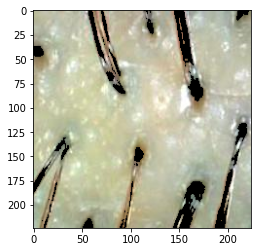

In [7]:
from matplotlib.pyplot import imshow

ii=np.zeros([224,224,1])
ii=train_set[0][0][-1]
dd=ii*255
dst1= cv2.inRange(dd, (100,100, 0), (255,255 , 255))

d=cv2.bitwise_and(ii, ii, mask=dst1)
imshow(d)

In [8]:
# image preprocessing
from matplotlib.pyplot import imshow
%matplotlib inline
for i in range(len(train_set)-1):
    print('i',i,end='\r')
    for j in range(32):
    
        ii=np.zeros([224,224,3])
        ii=train_set[i][0][j]
        
        dd=ii*255
        dst1= cv2.inRange(dd, (100,100, 0), (255,255 , 255))


        train_set[i][0][j] = cv2.bitwise_and(ii, ii, mask=dst1)

for i in range(len(val_set)-1):
    print('ii',i,end='\r')
    for j in range(32):
    
        ii=np.zeros([224,224,3])
        ii=val_set[i][0][j]
        
        dd=ii*255
        dst1= cv2.inRange(dd, (100,100, 0), (255,255 , 255))



        val_set[i][0][j] = cv2.bitwise_and(ii, ii, mask=dst1)
for i in range(len(test_set)-1):
    print('iii',i,end='\r')
    for j in range(32):
    
        ii=np.zeros([224,224,3])
        ii=test_set[i][0][j]
        
        dd=ii*255
        dst1= cv2.inRange(dd, (100,100, 0), (255,255 , 255))



        test_set[i][0][j] = cv2.bitwise_and(ii, ii, mask=dst1)

In [9]:
class_path = glob.glob(train_dir + '/*')
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

train set의 이미지 클래스: {'folliculitis_0': 0, 'folliculitis_1': 1, 'folliculitis_2': 2, 'folliculitis_3': 3}
test set의 이미지 클래스: {'folliculitis_0': 0, 'folliculitis_1': 1, 'folliculitis_2': 2, 'folliculitis_3': 3}
validation set의 이미지 클래스: {'folliculitis_0': 0, 'folliculitis_1': 1, 'folliculitis_2': 2, 'folliculitis_3': 3}


{0: 2022, 1: 2126, 2: 2157, 3: 2141}

In [10]:
conv_base = ResNet50V2(include_top=False, weights = 'imagenet' ,input_shape=(224,224,3))
conv_base.summary()
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 36,410,500
Trainable params: 36,365,060
Non-trainable params: 45,440
_________________________________________________________________


In [11]:
# 50
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)

# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('logs/f_resnet_1.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=5)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])

history =model.fit(train_set,
                    epochs=epochs,
                    validation_data=val_set,
                    callbacks=callbacks
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 264 steps, validate for 42 steps
Epoch 1/20
264/264 [==============================] - 114s 433ms/step - loss: 0.8786 - acc: 0.6356 - val_loss: 1.2372 - val_acc: 0.6039
Epoch 2/20
264/264 [==============================] - 98s 373ms/step - loss: 0.3340 - acc: 0.8638 - val_loss: 0.8441 - val_acc: 0.7127
Epoch 3/20
264/264 [==============================] - 96s 365ms/step - loss: 0.1744 - acc: 0.9352 - val_loss: 0.9762 - val_acc: 0.7224
Epoch 4/20
264/264 [==============================] - 99s 374ms/step - loss: 0.1345 - acc: 0.9518 - val_loss: 1.3538 - val_acc: 0.6864
Epoch 5/20
264/264 [==============================] - 97s 368ms/step - loss: 0.0930 - acc: 0.9668 - val_loss: 1.2477 - val_acc: 0.6992
Epoch 6/20
264/264 [==============================] - 96s 364ms/step - loss: 0.0731 - acc: 0.9734 - val_loss: 1.2425 - val_acc: 0.7127
Epoch 7/20
264/264 [==============================] - 97s 366ms/step - loss: 0.0734 - acc: 0.974

---

In [8]:
(test_loss, test_accuracy) = model.evaluate(test_set, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

  ...
    to  
  ['...']
17/17 [==============================] - 3s 172ms/step - loss: 2.2582 - acc: 0.6573
Test loss: 2.2581590554293465
Test accuracy: 65.73033928871155


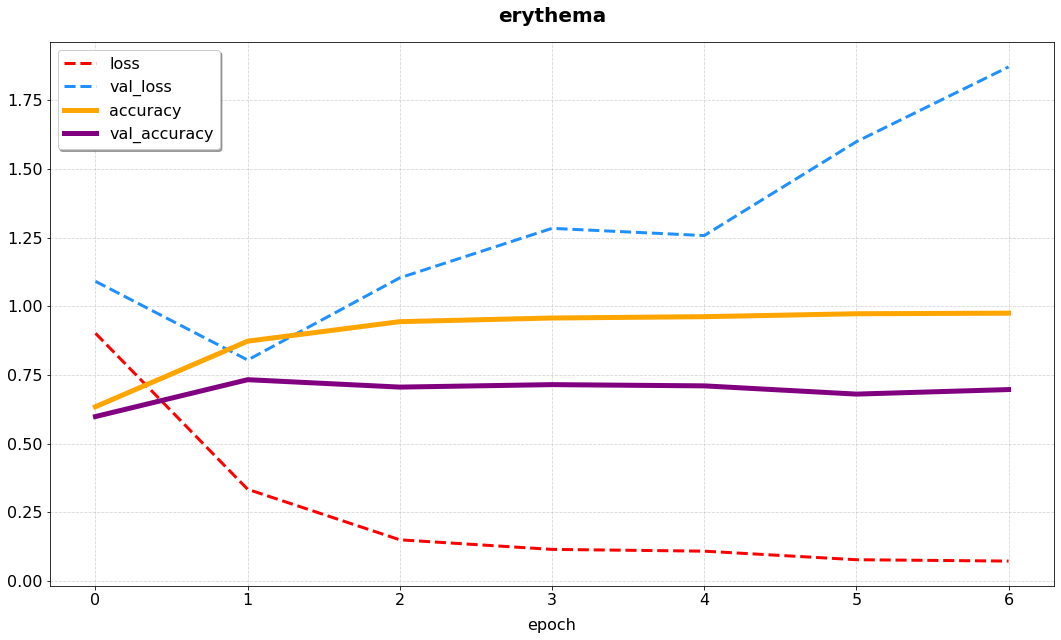

In [9]:
font1 = {'family': 'DejaVu Sans',
         'weight': 'bold',
         'size': 20
         }

font2 = {'family': 'DejaVu Sans',
         'size': 16
         }   

plt.figure(figsize=(18,10))

plt.plot(history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(history.history['acc'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(history.history['val_acc'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('erythema', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

---

In [4]:
for i in range(len(test_set)-1):
    print('iii',i,end='\r')
    for j in range(32):
    
        ii=np.zeros([224,224,3])
        ii=test_set[i][0][j]
        
        dd=ii*255
        dst1= cv2.inRange(dd, (100,100, 0), (255,255 , 255))



        test_set[i][0][j] = cv2.bitwise_and(ii, ii, mask=dst1)

In [6]:
from tensorflow.keras.models import load_model
model=load_model('logs/f_resnet_1.h5')

In [7]:
dd = model.evaluate_generator(test_set,32)
dd

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[0.4532875008881092, 0.6741573]

In [10]:
test_set.reset()
Y_pred = model.predict_generator(test_set)#validation_generator.n // validation_generator.batch_size+1)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1) 

cm=confusion_matrix(test_set.classes, y_pred)
tot=np.sum(cm,axis=1)
cm1=cm/tot[:,None]
classes=['0','1','2','3']

array([[0.18421053, 0.61842105, 0.15789474, 0.03947368],
       [0.14851485, 0.69636964, 0.10231023, 0.05280528],
       [0.2037037 , 0.61111111, 0.11111111, 0.07407407],
       [0.10638298, 0.82978723, 0.0212766 , 0.04255319]])